In [1]:
## This code looks at a single track and plots
## the Chord Length and Lead Width distributions

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import load_in_beam
import FSDutil
import seaborn as sns
import ice_plot
import cartopy.crs as ccrs
import os

In [2]:
ATL07file='processed_ATL07-01_20181121010613_08160101_001_01.h5'
# ATL07file='processed_ATL07-01_20181206115828_10520101_001_01.h5'
localFilePath='/home/jovyan/Data/'+ATL07file

ds1r = load_in_beam.read_beam(filename=localFilePath,beam='gt1r')

/home/jovyan/Data/processed_ATL07-01_20181121010613_08160101_001_01.h5


In [3]:
namer = ['gt1r','gt2r'] # 
# weak beams are 'gt1l', 'gt2l', 'gt3l'
# 'gt3r' is missing a field

CLD = []
LWD = []
latlead = []
latfloe = []
lonlead = []
lonfloe = []

for beam_ind in range(len(namer)):

    beam_data = load_in_beam.read_beam(filename=localFilePath,beam=namer[beam_ind]);
    newCLD,new_latfloe,new_lonfloe = FSDutil.get_CLD(beam_data)
    newLWD,new_latlead,new_lonlead = FSDutil.get_LWD(beam_data)
    
    CLD = np.concatenate([CLD,newCLD])
    LWD = np.concatenate([LWD,newLWD])
    latlead = np.concatenate([latlead,new_latlead])
    lonlead = np.concatenate([lonlead,new_lonlead])
    latfloe = np.concatenate([latfloe,new_latfloe])
    lonfloe = np.concatenate([lonfloe,new_lonfloe])
    

/home/jovyan/Data/processed_ATL07-01_20181121010613_08160101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181121010613_08160101_001_01.h5


In [4]:
# Load in concentration data

nrt_dir = '/home/jovyan/Data/NSIDC_0081/'

# Get recent observations NH only
ds_81 = xr.open_mfdataset(nrt_dir+'/*.nc', concat_dim='time', autoclose=True, parallel=True)
cd = beam_data.time[0].values  # get the first time in our track
cd = pd.to_datetime(cd).strftime('%Y-%m-%d') # convert time format to get rid of seconds
print('Got the sea ice obs on this date:',cd)
# convert time format of obs to match
ds_81['time'] = pd.to_datetime(ds_81.time.values).strftime('%Y-%m-%d') 

# select the SIC for the day of our track
obs = ds_81.sic.sel(time=cd)

Got the sea ice obs on this date: 2018-11-21


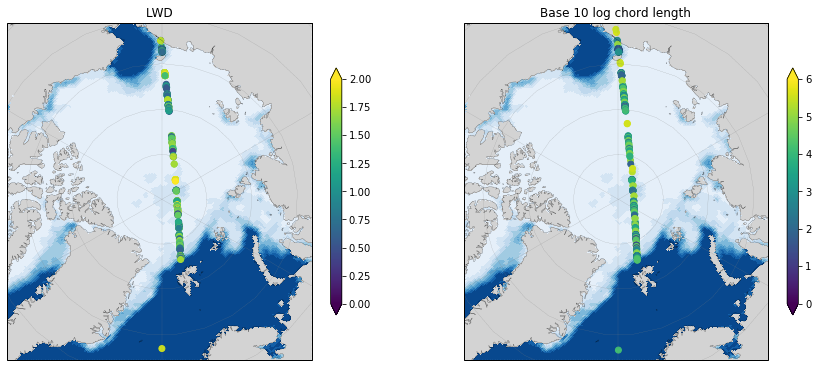

In [5]:
# What variable to plot 

cvar='Lead Width (log)'


cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

# (f, axes) = ice_plot.multi_polar_axis(ncols=1, nrows=2, Nplots=4, sizefcter=5, extent=central_extent, central_longitude=0)
(f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=2, Nplots=3,sizefcter=5,extent=central_extent, central_longitude=0)

print(axes)
i=0
obs_h1 = obs.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

# put on the track
Lead_Track = axes[0].scatter(lonlead, latlead, c=np.log10(LWD), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=2)
axes[0].set_title('LWD');
f.colorbar(Lead_Track,ax=axes[0],shrink=0.5,extend='both')

# f.colorbar(track, label=cvar, shrink=0.5, extend='both')
# cbar_ax = f.add_axes([0.55, 0.325, 0.015, 0.35])
# cbar = f.colorbar(obs_h, cax=cbar_ax, label='Sea Ice Concentration', orientation='vertical')

i=1
obs_h2 = obs.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

# put on the track
Chord_Track = axes[1].scatter(lonfloe, latfloe, c=np.log10(CLD), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=6)
axes[1].set_title('Base 10 log chord length');
f.colorbar(Chord_Track,ax=axes[1],shrink=0.5,extend='both')

# axes[i].title('CLD')
# f_out = os.path.join(fig_dir,ATL07file+'_seg_lengths.png')
# print(f_out)
# plt.savefig(f_out,bbox_inches='tight', dpi=200)

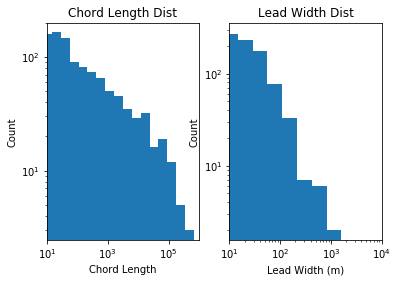

In [6]:
xbuckets = np.logspace(0, 7, num=25, endpoint=True, base=10.0, dtype=None)
hist,edges = np.histogram(CLD,xbuckets)

fig, ax2 = plt.subplots(1, 2);
ax2[0].hist(CLD,bins=edges);
ax2[0].set(yscale='log',xscale='log',xlim=(1e1,1e6),xlabel='Chord Length',ylabel='Count',title='Chord Length Dist');

ax2[1].hist(LWD,bins=edges);
ax2[1].set(yscale='log',xscale='log',xlim=(1e1,1e4),xlabel='Lead Width (m)',ylabel='Count',title='Lead Width Dist');